In [3]:
# setup
# file
import os

# Data Processing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# explain
import seaborn as sns
import shap

# folder
folder_input = '02_input'



In [4]:
# import data and data cleansing
# original data
org = pd.read_csv(os.path.join('..', folder_input, 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))

cleaned_data = org.copy()

# target (turn to bool)
cleaned_data = org.copy()
cleaned_data['Churn'] = cleaned_data['Churn'] == "Yes"

# total charges - " " to 0
cleaned_data['TotalCharges'] = cleaned_data['TotalCharges'].str.replace(" ", "0", case=False, regex=False)
cleaned_data = cleaned_data.astype({'TotalCharges': 'float64'})

# drop useless cols
cleaned_data = cleaned_data.drop(
    labels=['customerID'],
    axis=1
)

# preprocessing for categorical data
cleaned_data.info()

# train vs test
# seperate target from predictors
X = cleaned_data.copy()            # use copy, not to affect original dataset
y = X.pop('Churn')        # y = "churn", and delete churn from X

# train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [5]:
# select categorical & numericial columns
# PS: [categorical_cols] mean == True
# PS: enable_categorical = True is not enabled for xgb classification yet (error: ValueError: Experimental support for categorical data is not implemented for current tree method yet.)
categorical_cols = X_train.dtypes == 'object'
categorical_cols = list(categorical_cols[categorical_cols].index)  
categorical_cols    

# one hot encoder
# PS: The one hot encoder output is a series, need to turn to dataframe
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[categorical_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.fit_transform(X_test[categorical_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# add back colnames
OH_cols_train.columns = OH_encoder.get_feature_names_out()
OH_cols_test.columns = OH_encoder.get_feature_names_out()


# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(categorical_cols, axis=1)
num_X_test = X_test.drop(categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_test = pd.concat([num_X_test, OH_cols_test], axis=1)


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [6]:
X_train.head()
y_train.head()

X_test.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2200,0,19,58.20,1045.25,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4627,0,60,116.60,7049.50,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3225,0,13,71.95,923.85,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2828,0,1,20.45,20.45,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3768,0,55,77.75,4266.40,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [7]:
# xgboost
xgbmodel = XGBClassifier(n_estimators = 1000)
xgbmodel.fit(
    X_train,
    y_train
)

# prediction
preds = xgbmodel.predict(X_test)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['No' 'Yes']

In [ ]:
# evaluation
accuracy_score(y_test, preds)

0.7597955706984668

In [ ]:
# confusion matrix
confusion_matrix(y_test, preds)

array([[1112,  186],
       [ 237,  226]], dtype=int64)

In [ ]:
# classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.82      0.86      0.84      1298
        True       0.55      0.49      0.52       463

    accuracy                           0.76      1761
   macro avg       0.69      0.67      0.68      1761
weighted avg       0.75      0.76      0.76      1761



<Axes: >

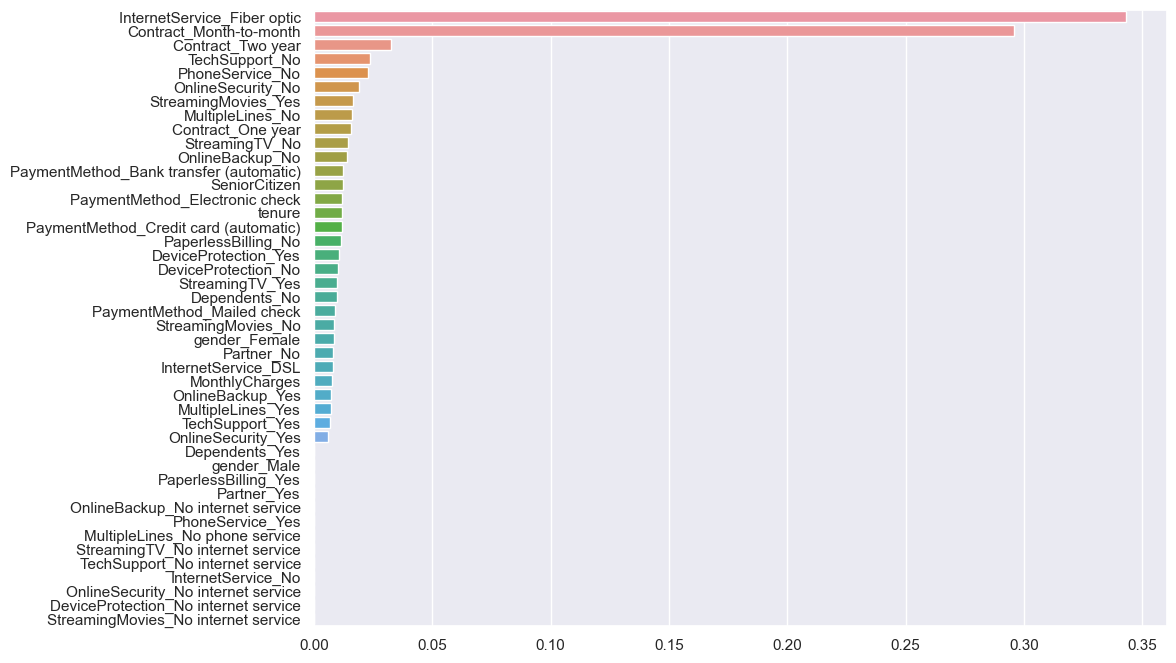

In [ ]:
# feature importance
xgb_importance = pd.Series(xgbmodel.feature_importances_, index=X_train.columns).sort_values(ascending= False)
xgb_importance

# plot it
sns.set(rc={'figure.figsize':(11,8)})
sns.barplot(x = xgb_importance.values,
            y = xgb_importance.index)